 # Benzamidine binding to Trypsin

In [1]:
import pyemma
pyemma.__version__

u'1.2.1+214.g2effeee'

This notebook has been tested for version 1.2.1. If you are using a different version some adaptations may be required.
Now we import a few general packages, including basic numerics and algebra routines (numpy) and plotting routines (matplotlib), and makes sure that all plots are shown inside the notebook rather than in a separate window (nicer that way).

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


Now we import the PyEMMA modules required later.

In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mpl
from pyemma import config

In [4]:
def save_figure(name):
    # change these if wanted
    do_save = True
    fig_dir = './figs/'
    if do_save:
        savefig(fig_dir + name, bbox_inches='tight')

## Trypsin/Benzamidine - load data

In [5]:
indir = './data'
topfile =  indir+'/tryp_ben_protein.pdb'
traj_list = []
for filename in os.listdir(indir):
    if filename.endswith('-200ns.xtc'):
        traj_list.append(os.path.join(indir,filename))

We can decide here which coordinates we would like to use in the further analysis.

In [6]:
feat = coor.featurizer(topfile)
n_res = 223 # number of residues
ben_ind = 225 # benzamidine index (with residues starting at 1)
ind_arr = np.zeros((n_res,2))
for i in range(n_res):
    ind_arr[i][0] = ben_ind-1
    ind_arr[i][1] = i
feat.add_residue_mindist(residue_pairs=(ind_arr), scheme='closest-heavy', ignore_nonprotein=False, threshold=0.5)
#feat.describe()

In [7]:
inp = coor.source(traj_list, feat)
print 'number of trajectories = ',inp.number_of_trajectories()
print 'trajectory length = ',inp.trajectory_length(0)
print 'number of dimension = ',inp.dimension()

number of trajectories =  50
trajectory length =  200
number of dimension =  223


We would also like to know the total number of contacts for each frame to analyze the binding.

In [8]:
contact_trajs = inp.get_output()

In [9]:
ct = np.array(contact_trajs)
contact_array = np.zeros((inp.number_of_trajectories(),inp.trajectory_length(0)))
for i in range(inp.number_of_trajectories()):
    for j in range(inp.trajectory_length(0)):
        contact_array[i][j] = sum(contact_trajs[i][j])

## TICA and clustering

In [10]:
tica_lag = 20      # tica lagtime

In [11]:
tica_obj = coor.tica(inp, lag=tica_lag, kinetic_map=True, var_cutoff=0.75)#, dim=tica_dim)

2015-07-28 18:19:16,235 coordinates.transform.TICA[1] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-28 18:19:16,236 coordinates.transform.TICA[1] INFO     Running TICA with tau=20; Estimating two covariance matrices with dimension (223, 223)


17


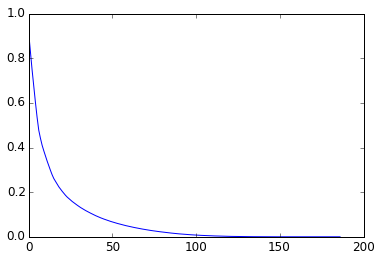

In [12]:
print tica_obj.dimension()
cum_variance = tica_obj.cumvar
plot(1-cum_variance)

In [13]:
Y = tica_obj.get_output() # get tica coordinates

/storage/mi/nplattner/miniconda/envs/PyE-devR/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


<matplotlib.contour.QuadContourSet instance at 0x7f9d2abea7a0>

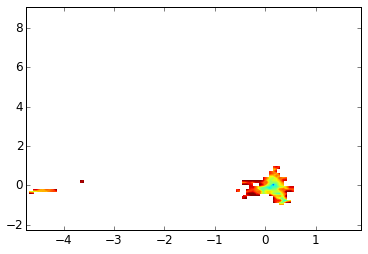

In [14]:
npY = np.array(Y)
npYc = np.concatenate(npY)
# histogram data
z,x,y = np.histogram2d(npYc[:,0],npYc[:,1], bins=100)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
contourf(F.T, 100,extent=extent)

### Clustering

In [15]:
n_clusters = 200      # number of k-means clusters
cl_metric = 'euclidean' # clustering metric

In [16]:
clustering = coor.cluster_kmeans(Y,k=n_clusters,max_iter=1000)

2015-07-28 18:20:04,614 coordinates.clustering.KmeansClustering[2] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-28 18:20:05,075 coordinates.clustering.KmeansClustering[2] INFO     Accumulated all data, running kmeans on (10000, 17)
2015-07-28 18:20:05,377 coordinates.clustering.KmeansClustering[2] INFO     Cluster centers converged after 7 steps.


In [17]:
dtrajs = coor.assign_to_centers(Y, centers=clustering.clustercenters, stride=1, return_dtrajs=True, metric=cl_metric)

2015-07-28 18:20:05,381 coordinates.clustering.AssignCenters[4] INFO     reset (previous) parametrization state, since data producer has been changed.


In order to analyze the distribution of the data to the cluster centers we make a histogram of the discrete trajectories.

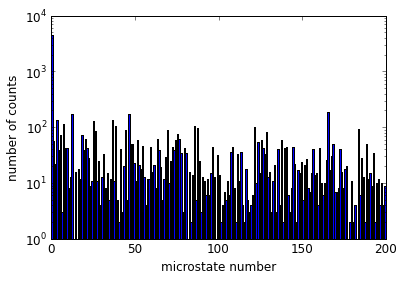

In [18]:
histogram = np.bincount(np.concatenate(dtrajs), minlength=len(clustering.clustercenters));
ind = np.arange(len(histogram))
plt.bar(ind, histogram, log=True)
plt.xlabel('microstate number')
plt.ylabel('number of counts')

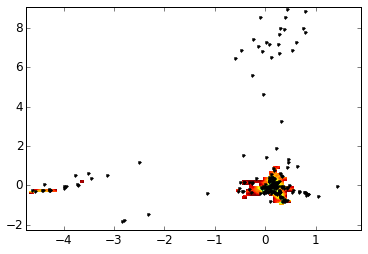

In [19]:
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
contourf(F.T, 100, extent=extent)
plot(cc_x,cc_y, linewidth=0, marker='.', color='black')

In [20]:
# analyze microstate distribution as a function of total number of contacts
nstates = len(clustering.clustercenters)
statecount = [0 for n in range(nstates)]
statedist = [0.0 for n in range(nstates)]
for i in range(len(dtrajs)):
    for j in range(len(dtrajs[i])):
        state = dtrajs[i][j]
        dist = contact_array[i][j]
        statecount[state] += 1
        statedist[state] += float(dist) 
distogram = np.zeros((nstates))
for i in range(nstates):
    distogram[i] = float(statedist[i])/float(statecount[i])

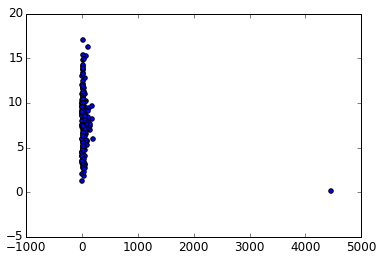

In [21]:
# did we resolve bound and unbound state?
scatter(histogram,distogram)

# Implied timescales

In [22]:
its = msm.timescales_msm(dtrajs, lags=50, nits=5, errors='bayes')

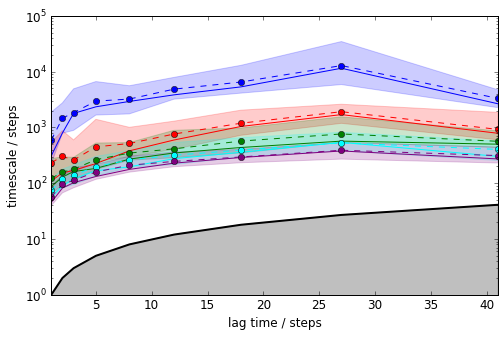

In [23]:
figure(figsize(8, 5))
mpl.plot_implied_timescales(its, ylog=True)
save_figure('its.png')

# Estimate MSM

In [24]:
M = msm.bayesian_markov_model(dtrajs, 10)
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

fraction of states used =  1.0
fraction of counts used =  1.0


(-0.5, 10.5)

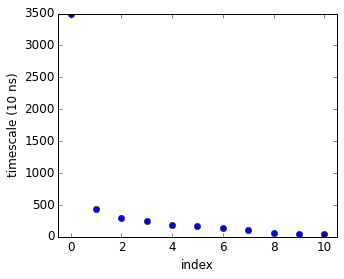

In [25]:
figure(figsize(5, 4))
plot(M.timescales(),linewidth=0,marker='o')
xlabel('index'); ylabel('timescale (10 ns)'); xlim(-0.5,10.5)

(0.6, 1.05)

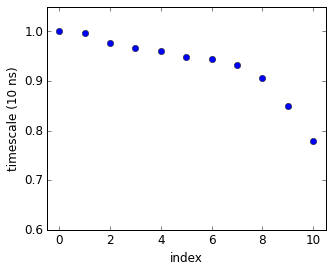

In [26]:
figure(figsize(5, 4))
plot(M.eigenvalues(),linewidth=0,marker='o')
xlabel('index'); ylabel('timescale (10 ns)'); xlim(-0.5,10.5) ;ylim(0.6,1.05)

In [27]:
# validate
cktest = M.cktest(4)

/storage/mi/nplattner/miniconda/envs/PyE-devR/lib/python2.7/site-packages/msmtools/analysis/dense/pcca.py:292: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))


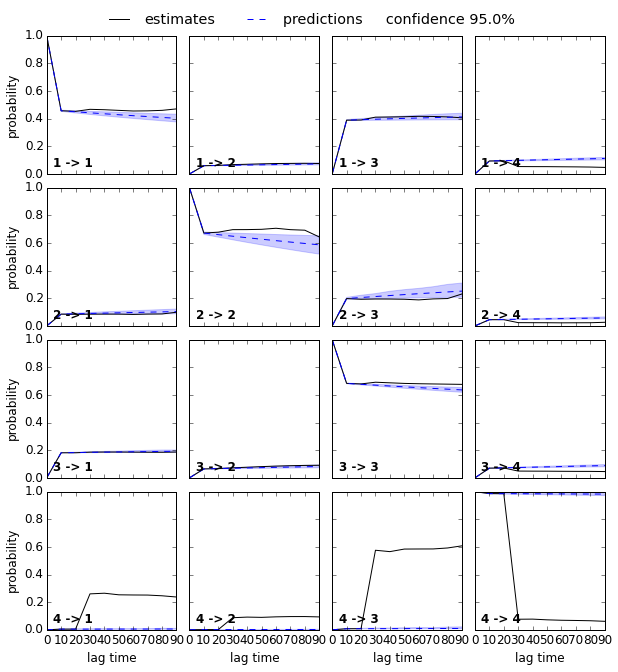

In [28]:
mpl.plot_cktest(cktest, padding_top=0.05)
save_figure('cktest.png')

In [29]:
pi = M.stationary_distribution # stationary distribution
F_pi = -np.log(pi)  # free energy based on stationary distribution

In [30]:
connected = M.connected_sets[0]
c_cc_x = cc_x[connected]
c_cc_y = cc_y[connected]

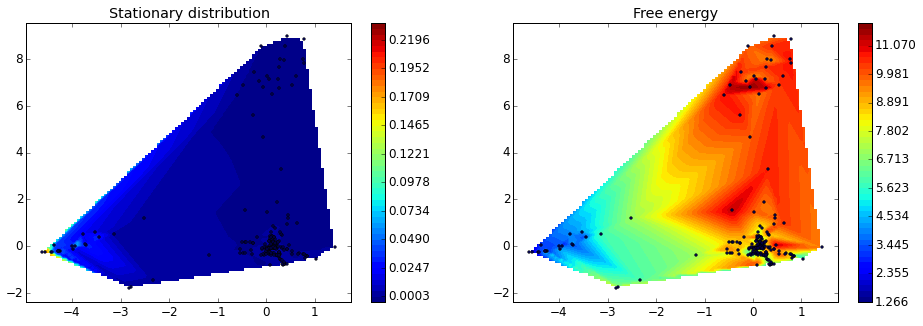

In [31]:
fig = plt.figure(figsize=(16,5))
matplotlib.rcParams.update({'font.size': 12})
ax1=plt.subplot(121)
ax1.set_title('Stationary distribution')
ax1 = mpl.scatter_contour(c_cc_x, c_cc_y, pi)

ax2=plt.subplot(122)
ax2.set_title('Free energy')
ax2 = mpl.scatter_contour(c_cc_x, c_cc_y, F_pi)

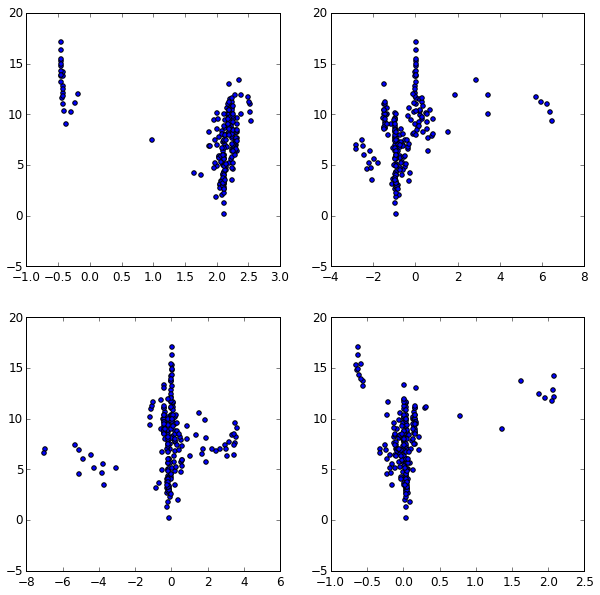

In [32]:
c_distogram = distogram[connected]
N=4
ngrid = int(math.ceil(sqrt(1.0*N)))
figure(figsize=(10,10))
for i in range(N):
    subplot2grid((ngrid,ngrid),(i/ngrid,i%ngrid))
    scatter(M.eigenvectors_right()[:,i+1], c_distogram)
    #semilogy()

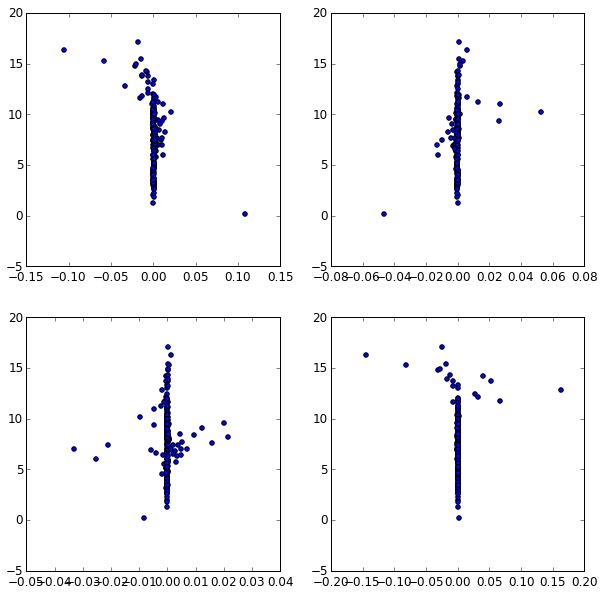

In [33]:
c_distogram = distogram[connected]
N=4
ngrid = int(math.ceil(sqrt(1.0*N)))
figure(figsize=(10,10))
for i in range(N):
    subplot2grid((ngrid,ngrid),(i/ngrid,i%ngrid))
    scatter(M.eigenvectors_left()[i+1], c_distogram)
    #semilogy()

# Free energy and association/dissociation constant as a function of lagtime

In [34]:
tdeltag = []
cnt = 0
lags = [1,2,5,10,15,20,25,30,35,40]
for tau in lags:
    model = msm.bayesian_markov_model(dtrajs, tau)
    mu = model.stationary_distribution
    # distances
    conn = model.connected_sets[0]
    dists = distogram[conn]
    tdeltag.append([])
    for lim in (0.5,1.0,1.5,2.0,3.0):
        pibound = 0
        for i in range(len(mu)):
            if dists[i] > lim:
                pibound += mu[i]
        punb = 1.0 - pibound
        fract = pibound/punb
        deltag = -((numpy.log(fract)*8.314 *298.0)/4148.0)
        tdeltag[cnt].append(deltag)
    #print tau, ['%7.6f' % val for val in tdeltag[cnt]]
    cnt += 1

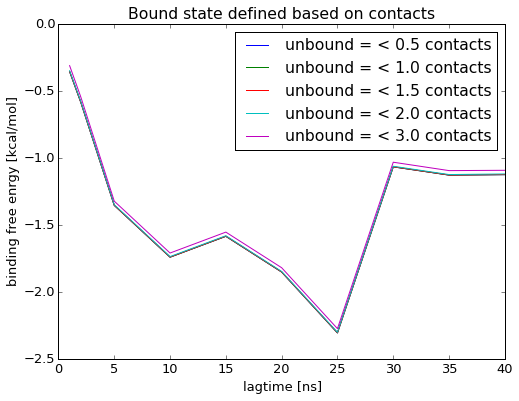

In [35]:
figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 13})
nptdeltag = numpy.array(tdeltag)
plot(lags,nptdeltag[:,0],label='unbound = < 0.5 contacts')
plot(lags,nptdeltag[:,1],label='unbound = < 1.0 contacts')
plot(lags,nptdeltag[:,2],label='unbound = < 1.5 contacts')
plot(lags,nptdeltag[:,3],label='unbound = < 2.0 contacts')
plot(lags,nptdeltag[:,4],label='unbound = < 3.0 contacts')
legend()
xlabel('lagtime [ns]')
ylabel('binding free enrgy [kcal/mol]')
title('Bound state defined based on contacts')
save_figure('contacts-time-deltag.png')

# Association and dissociation constant as a function of lagtime

In [36]:
# define bound and unbound states
blim = 1.0 # number of contacts to belong to bound states
ulim = 1.0 # number of contacts to belong to bound states
bound = []
unbound = []
M = msm.bayesian_markov_model(dtrajs,10)
c_distogram = distogram[M.connected_sets[0]]
for i in range(len(pi)):
    if c_distogram[i] > blim:
        bound.append(i)
    elif c_distogram[i] < ulim:
        unbound.append(i)

In [37]:
# unbound --> bound
umfpt = M.mfpt(unbound,bound)
print 'unbound to bound: ', umfpt
# bound --> unbound
bmfpt = M.mfpt(bound,unbound)
print 'bound to unbound: ', bmfpt
# k_on and k_off
concentration = 0.015 # concentration (Mol)
print 'k_on  experimental = 2.9x10**7 mol-1 sec-1'
print 'k_on: \t\t', (1./(umfpt*concentration))*10**2, '*10**7 mol-1 sec-1' # conversion to Mol-1 sec-1
print 'k_off experimental = 6*10**2 sec-1'
print 'k_off: \t\t', (1./bmfpt)*10**7, '*10**2 sec-1' # conversion to Mol-1 sec-1

unbound to bound:  49.445089257
bound to unbound:  18068.4725077
k_on  experimental = 2.9x10**7 mol-1 sec-1
k_on: 		134.829702339 *10**7 mol-1 sec-1
k_off experimental = 6*10**2 sec-1
k_off: 		553.450215325 *10**2 sec-1


In [38]:
tbmfpt = []
tumfpt = []
tk_on = []
tk_off = []
cnt = 0
lags = [1,2,5,10,15,20,25,30,35,40]
for tau in lags:
    model = msm.bayesian_markov_model(dtrajs, tau)
    # distances
    conn = model.connected_sets[0]
    dists = distogram[conn]
    bd = []
    ubd = []
    for i in range(len(dists)):
        if dists[i] > blim:
            bd.append(i)
        elif dists[i] < ulim:
            ubd.append(i)
    umf = model.mfpt(ubd,bd)
    bmf = model.mfpt(bd,ubd)
    tbmfpt.append(bmf)
    tumfpt.append(umf)
    tk_on.append((1./(umf*concentration))*10**2)
    tk_off.append((1./(bmf))*10**7)
    #print tau,'\t',umf,'\t',bmf,'\t',(1./(umf*concentration))*10**2,'\t',(1./(bmf))*10**7
    cnt += 1

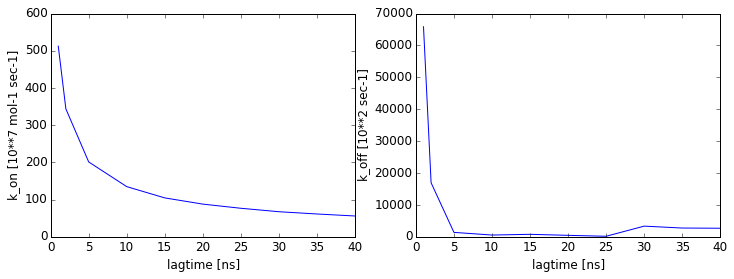

In [39]:
fig = plt.figure(figsize=(12,4))
matplotlib.rcParams.update({'font.size': 12})
ax1=plt.subplot(121)
xlabel('lagtime [ns]')
ylabel('k_on [10**7 mol-1 sec-1]')
ax1 = plot(lags,tk_on)

ax2=plt.subplot(122)
xlabel('lagtime [ns]')
ylabel('k_off [10**2 sec-1]')
ax2 = plot(lags,tk_off)

# PCCA

In [40]:
n_sets = 4
M.pcca(n_sets)
pcca_dist = M.metastable_distributions
membership=M.metastable_memberships  # get PCCA memberships

In [41]:
for i in range(n_sets):
    print np.dot(membership[:,i],pi)

0.0425819285428
0.0298159145651
0.0913248043074
0.836277352585


In [42]:
# average total number of contacts and PCCA_set
c_distogram = distogram[connected]
mnorm = np.arange(len(pi))
for i in range(n_sets):
    mnorm[i] = np.sum(membership[:,i])
for i in range(n_sets):
    print i, np.dot(membership[:,i],c_distogram)/(mnorm[i])

0 6.95081882471
1 8.69143095125
2 7.20020990837
3 10.9393052999


In [43]:
pcca_samples = M.sample_by_distributions(pcca_dist, 10)

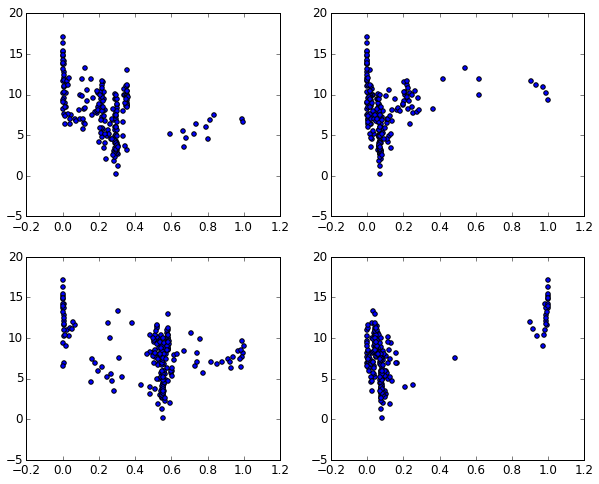

In [44]:
c_distogram = distogram[connected]
fig = plt.figure(figsize=(10,8))

ax1=plt.subplot(221)
ax1 = scatter(membership[:,0],c_distogram)

ax2=plt.subplot(222)
ax1 = scatter(membership[:,1],c_distogram)

ax3=plt.subplot(223)
ax1 = scatter(membership[:,2],c_distogram)

ax4=plt.subplot(224)
ax1 = scatter(membership[:,3],c_distogram)

In [45]:
coor.save_traj(inp, pcca_samples[0], './out_mindists/pcca1_10samples.xtc')
coor.save_traj(inp, pcca_samples[1], './out_mindists/pcca2_10samples.xtc')
coor.save_traj(inp, pcca_samples[2], './out_mindists/pcca3_10samples.xtc')
coor.save_traj(inp, pcca_samples[3], './out_mindists/pcca4_10samples.xtc')

2015-07-28 18:22:07,205 coordinates.api INFO     Created file ./out_mindists/pcca1_10samples.xtc
2015-07-28 18:22:08,731 coordinates.api INFO     Created file ./out_mindists/pcca2_10samples.xtc
2015-07-28 18:22:11,225 coordinates.api INFO     Created file ./out_mindists/pcca3_10samples.xtc
2015-07-28 18:22:12,446 coordinates.api INFO     Created file ./out_mindists/pcca4_10samples.xtc


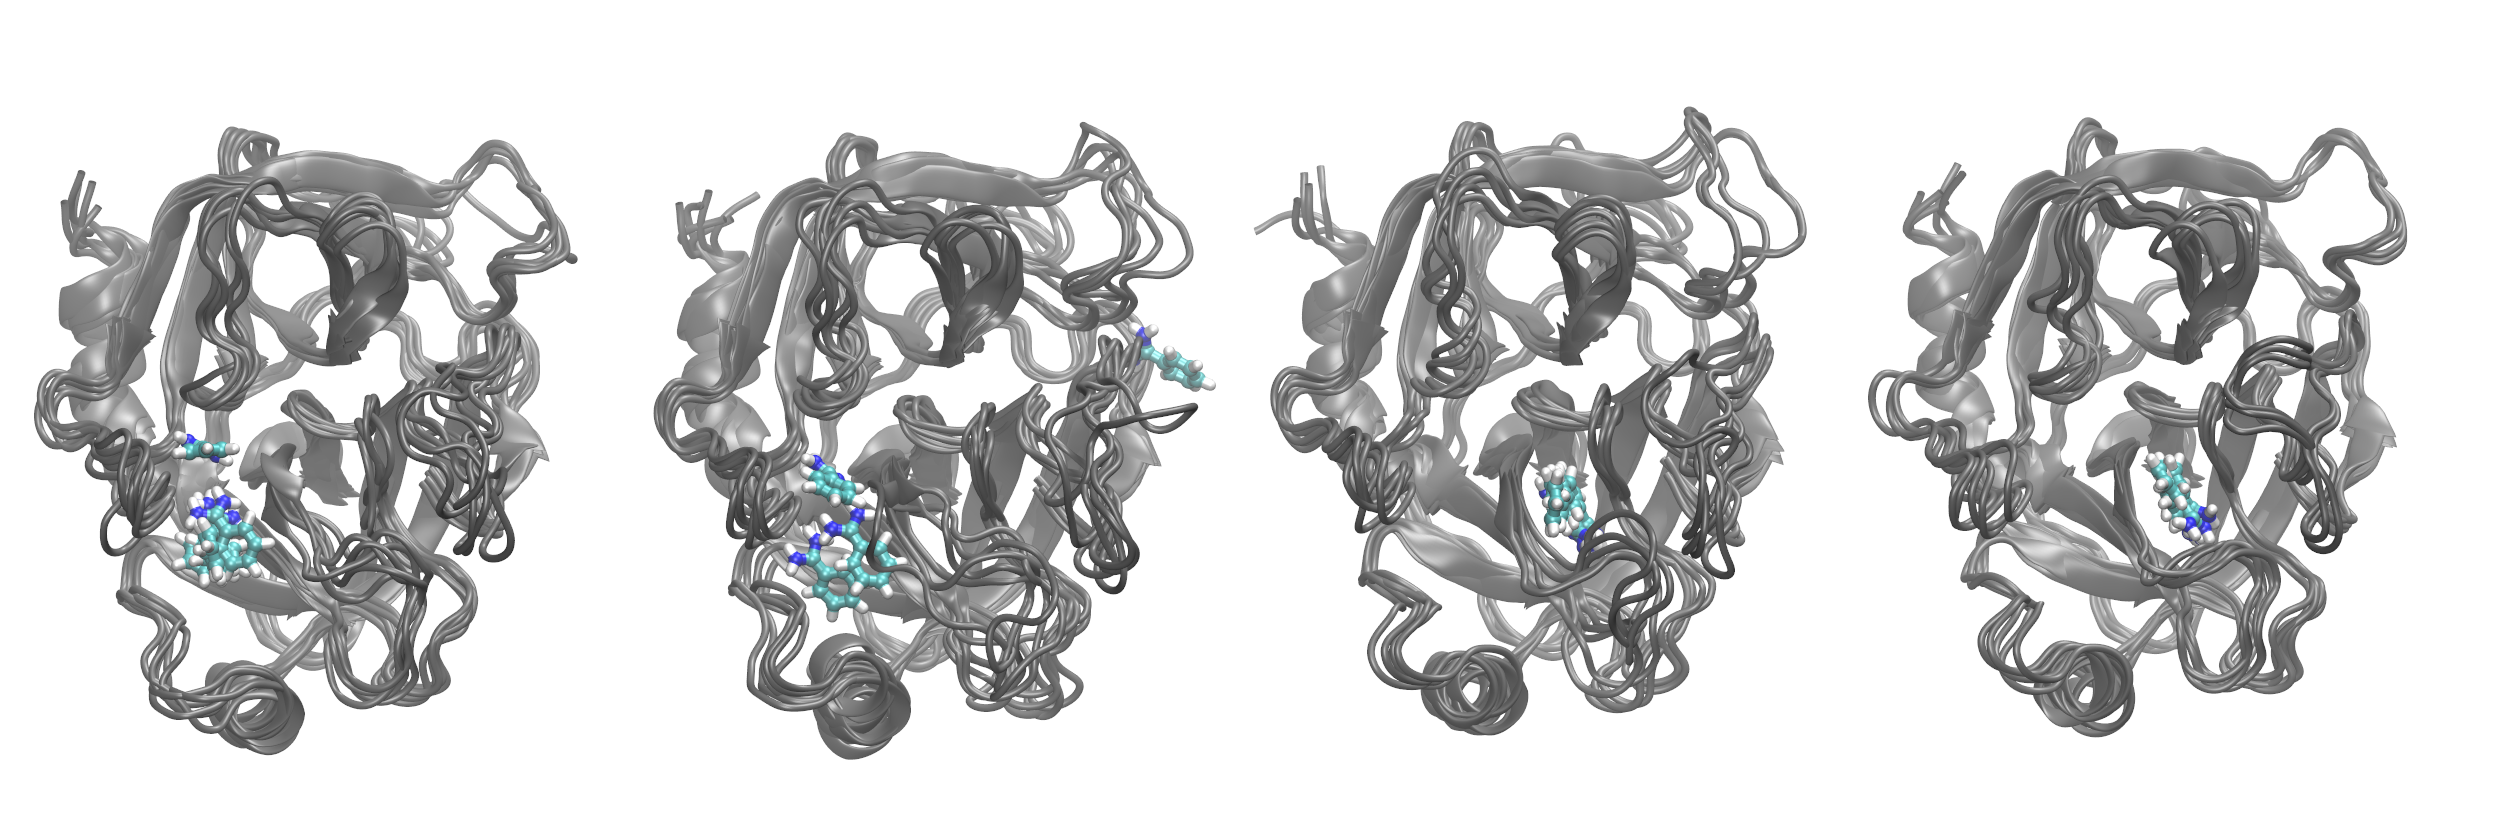

In [46]:
from IPython.display import Image
Image(filename='./out_mindists/con_mindists-pcca.png', width=1000)

# Coarse-grained kinetic Model using a Hidden Markov Model

In [47]:
hmm = M.coarse_grain(4)

2015-07-28 18:22:12,517 MaximumLikelihoodHMSM[0x7f9d1c8bbc90] WARNING  Requested coarse-grained model with 4 metastable states at lag=10.The ratio of relaxation timescales between 4 and 5 states is only 1.1594329379 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


In [48]:
hmm = msm.estimate_hidden_markov_model(dtrajs,4,lag=10)

2015-07-28 18:22:49,751 MaximumLikelihoodHMSM[0x7f9d1f8fda90] WARNING  Requested coarse-grained model with 4 metastable states at lag=10.The ratio of relaxation timescales between 4 and 5 states is only 1.14183870134 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


In [49]:
hmm_pi = hmm.stationary_distribution
hmm_pi_obs = hmm.stationary_distribution_obs
print hmm_pi

[ 0.31788237  0.12237519  0.08895562  0.47078682]


In [50]:
#hmm_samples = hmm.sample_by_observation_probabilities(10)

In [51]:
#coor.save_traj(inp, hmm_samples[0], './out_hmm/hmm_samples_1.xtc')
#coor.save_traj(inp, hmm_samples[1], './out_hmm/hmm_samples_2.xtc')
#coor.save_traj(inp, hmm_samples[2], './out_hmm/hmm_samples_3.xtc')
#coor.save_traj(inp, hmm_samples[3], './out_hmm/hmm_samples_4.xtc')

In [52]:
its = msm.timescales_hmsm(dtrajs,3,lags=50)

2015-07-28 18:23:28,940 MaximumLikelihoodHMSM[0x7f9d220a4250] WARNING  Requested coarse-grained model with 3 metastable states at lag=1.The ratio of relaxation timescales between 3 and 4 states is only 1.26678209987 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-07-28 18:23:33,329 MaximumLikelihoodHMSM[0x7f9d1da75290] WARNING  Requested coarse-grained model with 3 metastable states at lag=2.The ratio of relaxation timescales between 3 and 4 states is only 1.27940459857 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-07-28 18:23:38,241 MaximumLikelihoodHMSM[0x7f9d1f94de50] WARNING  Requested coarse-grained model with 3 metastable states at lag=3.The ratio of relaxation timescales between 3 and 4 states is only 1.03040690526 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-07-28 18:24:14,612 MaximumLik

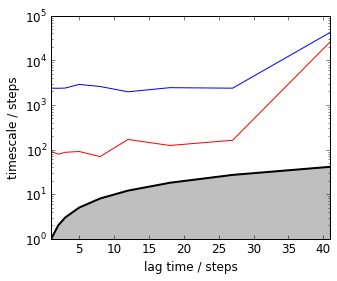

In [53]:
mpl.plot_implied_timescales(its)

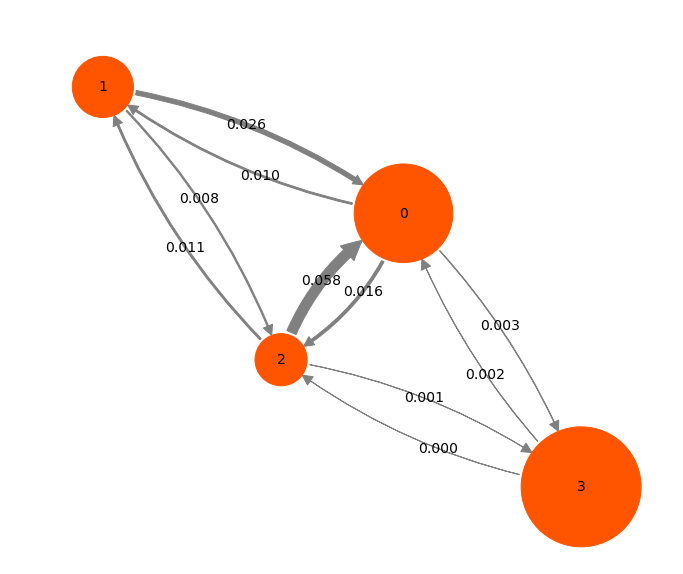

In [54]:
#pos=np.array([[0.0,0],[2,1],[4,4],[0,4]])
mpl.plot_markov_model(hmm, minflux=1e-9, arrow_label_format='%.3f')
gca().set_frame_on(False)
save_figure('network.png')